In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants

from setlearn.data import modelnet as dmodel

print( "The tensorflow version is {}.".format( tf.__version__ ) )

The tensorflow version is 1.11.0.


In [2]:
np.random.seed( seed=10001 ) # 2718 ) # 
tf.set_random_seed( 10001 ) # 2718 ) # 

In [3]:
EPOCHS = 100 # pick something that makes you happy
NUM_CLASSES = 2 # held out for fine-tuning

NUM_FEATURES = 256 # inherited from the JO's deepset model

In [4]:
num_points = 10000
model_path = './model_test_92/' # the highest numbered model_test should have the best accuracy
data_path  = './data/ModelNet38_cloud.h5' # the training data (probably don't need)

# retrain_path = './data/ModelNet02_cloud.h5' # held out data file
# task_name = 'air_bed_{}'.format( num_points )

# retrain_path = './data/ModelNet02_cloud.h5' # held out data file
# task_name = 'bowl_cone_{}'.format( num_points )

retrain_path = './data/medicalnet02_cloud.h5' # held out data file
task_name = 'med_{}'.format( num_points )

batch_size = 12 # 128 # pick something that best utilizes the gpu

In [5]:
img_path = os.path.join( '../images/', task_name )
os.makedirs( img_path, exist_ok=True )

In [6]:
retrain_fetcher = dmodel.ModelFetcher( 
    retrain_path, 
    batch_size=batch_size, 
)

In [7]:
loss_val = 0 # initialize loss value

In [8]:
graph_ld = tf.Graph()
with graph_ld.as_default():
    with tf.variable_scope( 'fine_tune' ):
        w = tf.get_variable( 
            'matrix', 
            shape=(NUM_FEATURES, NUM_CLASSES), 
            dtype=tf.float32, 
            initializer=tf.initializers.random_normal
        )
        
        b = tf.get_variable( 
            'bias', 
            shape=(NUM_CLASSES,), 
            dtype=tf.float32, 
            initializer=tf.initializers.random_normal
        )
    
    with tf.variable_scope( 'opt' ):
        global_step = tf.Variable( 0, trainable=False )
        learning_rate = tf.train.exponential_decay( 
            learning_rate=0.0005, 
            global_step=global_step, 
            decay_steps=( 100000 // ( batch_size ) ), 
            decay_rate=0.95, 
            staircase=True 
        )
        
#         opt = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ) #.minimize( loss )
#         opt = tf.train.AdamOptimizer( learning_rate=learning_rate, beta1=0.9, beta2=0.99 ) #.minimize( loss )
        opt = tf.train.RMSPropOptimizer( learning_rate ) #.minimize( loss )
        
    with tf.Session(graph=graph_ld) as sess:
#         sess.run( tf.initializers.global_variables() )
        sess.run( tf.initialize_all_variables() )
        
        print( "Restoring model..." )
        tf.saved_model.loader.load(
            sess,
            [tag_constants.SERVING],
            model_path
        )
        print( 'restored!')
        
        inputs_ph      = graph_ld.get_tensor_by_name( 'inputs:0' )
        cards_ph       = graph_ld.get_tensor_by_name( 'cards:0' )
        ys_ph          = graph_ld.get_tensor_by_name( 'ys:0' )
        is_training_ph = graph_ld.get_tensor_by_name( 'is_training:0' )
        
        labels = tf.one_hot( ys_ph, depth=NUM_CLASSES )
        
        # Get the feature layer and lock the parameters down
        features = tf.stop_gradient(
            graph_ld.get_tensor_by_name( 'tens/reduce/normed_tensor:0' )
        )
        
        # Logits from a linear combination of features (super simple)
        # Replaces the original operation with a similar operation
        logits = tf.matmul( features, w ) + b
        
        loss = tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=labels
        )
        
        est = tf.nn.softmax( logits )
        
        avg_loss = tf.reduce_mean( loss )
        train_op = opt.minimize( avg_loss )
        
        # Initialize the optimizer's parameters
        var_list = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES )
        tmp = [opt.get_slot(var, name) for name in opt.get_slot_names() for var in var_list]
        opt_init_list = [x for x in tmp if x is not None] # remove Nones
        opt_reset = tf.variables_initializer( opt_init_list )
        
        sess.run( opt_reset )
        
        print( "Begin training!" )
        epoch_train_loss = []
        epoch_test_loss  = []
        
        final_est = []
        final_lbl = []
        
        epoch_train_acc = []
        epoch_test_acc  = []
        for ee in range( EPOCHS ): # 1 ): # 
            
            run_acc  = []
            run_loss = []
            train_data = retrain_fetcher.train_data( loss_val )
            for inps, cs, ms in train_data:
                feed_dict = {
                    inputs_ph: inps, 
                    cards_ph: cs, 
                    ys_ph: ms, 
                    is_training_ph: False
                }
                _, est_, labels_, loss_ = sess.run( 
                    [train_op, est, labels, avg_loss], 
                    feed_dict=feed_dict
                )
                
                est_ = np.round( est_ )
                acc = 1 - 0.5 * np.mean( np.abs( est_ - labels_ ) )
                
                run_acc.append( acc )
                run_loss.append( loss_ )
            epoch_train_loss.append( np.array( run_loss ) )
            epoch_train_acc.append( run_acc )
            
            cnt = 0
            run_acc  = []
            run_loss = []
            test_data = retrain_fetcher.test_data()
            for inps, cs, ms in test_data:
                cnt += 1
                
                feed_dict = {
                    inputs_ph: inps, 
                    cards_ph: cs, 
                    ys_ph: ms, 
                    is_training_ph: False
                }
                est_, labels_, loss_ = sess.run( 
                    [est, labels, avg_loss], 
                    feed_dict=feed_dict
                )
                
                if ( ee+1 == EPOCHS ):
                    final_est.append( est_ )
                    final_lbl.append( labels_ )
                    
                est_ = np.round( est_ )
                acc = 1 - 0.5 * np.mean( np.abs( est_ - labels_ ) )
                
                run_acc.append( acc )
                run_loss.append( loss_ )
            epoch_test_acc.append( np.array( run_acc ) )
            epoch_test_loss.append( np.array( run_loss ) )
            
        epoch_train_acc = np.concatenate( epoch_train_acc, axis=0 )
        epoch_test_acc  = np.concatenate( epoch_test_acc,  axis=0 )
        
        epoch_train_loss = np.concatenate( epoch_train_loss, axis=0 )
        epoch_test_loss  = np.concatenate( epoch_test_loss,  axis=0 )

est = np.concatenate( final_est, axis=0 )
lbl = np.concatenate( final_lbl, axis=0 )

print( 'Finished training!' )

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Restoring model...
INFO:tensorflow:Restoring parameters from ./model_test_92/variables/variables
restored!
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Train loss: 0.0000:   0%|          | 0/11 [00:00<?, ?it/s]

Begin training!


Test Iterations:  67%|██████▋   | 2/3 [00:00<00:00, 722.97it/s]

Finished training!


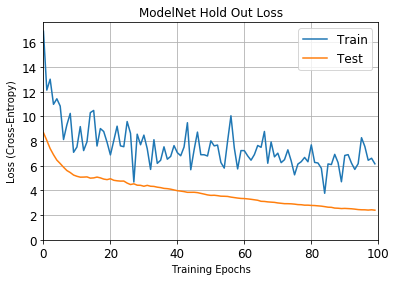

In [9]:
fig0 = plt.figure( )
ax0 = fig0.add_subplot( 1, 1, 1 )
ax0.plot( np.mean( np.reshape( epoch_train_loss, (EPOCHS,-1) ), axis=1 ) )
ax0.plot( np.mean( np.reshape( epoch_test_loss,  (EPOCHS,-1) ), axis=1 ) )

ax0.grid( True )
ax0.set_xlim( (0,EPOCHS) )
ax0.set_ylim( bottom=0 )

ax0.tick_params( axis='both', which='major', labelsize=12 )
ax0.set_xlabel( "Training Epochs" )
ax0.set_ylabel( "Loss (Cross-Entropy)" )
ax0.set_title( "ModelNet Hold Out Loss" )
ax0.legend( ("Train", "Test"), loc="upper right", fontsize="large" )

# fig0.savefig( os.path.join( img_path, 'loss.png' ), dpi=216, format='png' )

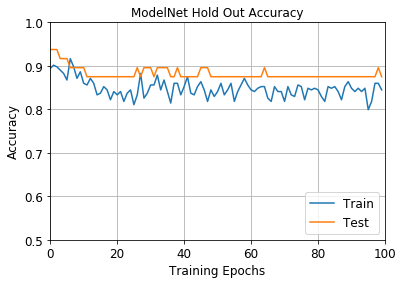

In [10]:
fig1 = plt.figure( )
ax1 = fig1.add_subplot( 1, 1, 1 )
ax1.plot( np.mean( np.reshape( epoch_train_acc, (EPOCHS,-1) ), axis=1 ) )
ax1.plot( np.mean( np.reshape( epoch_test_acc,  (EPOCHS,-1) ), axis=1 ) )

ax1.grid( True )
ax1.set_xlim( (0,EPOCHS) )
ax1.set_ylim( (0.5,1.0) )

ax1.tick_params( axis='both', which='major', labelsize=12 )
ax1.set_xlabel( "Training Epochs", fontsize="large" )
ax1.set_ylabel( "Accuracy", fontsize="large" )
ax1.set_title( "ModelNet Hold Out Accuracy", fontsize="large" )
ax1.legend( ("Train", "Test"), loc="lower right", fontsize="large" )

# fig1.savefig( os.path.join( img_path, 'acc.png' ), dpi=216, format='png' )

In [11]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range( 2 ):
    fpr[i], tpr[i], _ = roc_curve(lbl[:, i], est[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [12]:
def make_roc_fig( C ):
    fig = plt.figure()
    ax  = fig.add_subplot( 1, 1, 1 )
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.plot( fpr[C], tpr[C] )

    ax.grid( True )
    ax.set_xlim( (0,1) )
    ax.set_ylim( (0,1) )

    ax.tick_params( axis='both', which='major', labelsize=12 )
    ax.set_xlabel( "False Positives", fontsize="large" )
    ax.set_ylabel( "True Positives", fontsize="large" )
    ax.set_title( "Class {}: AUC={}".format( C, np.round( roc_auc[C], decimals=2 ) ), 
                 fontsize="large" )
    
    return fig

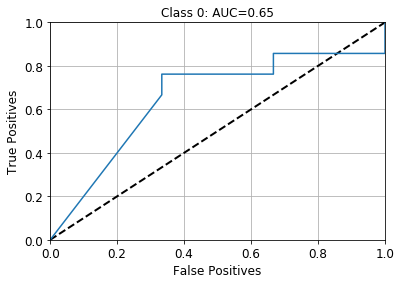

In [15]:
fig = make_roc_fig( 0 )
# fig.savefig( os.path.join( img_path, 'roc_0.png' ), dpi=216, format='png' )

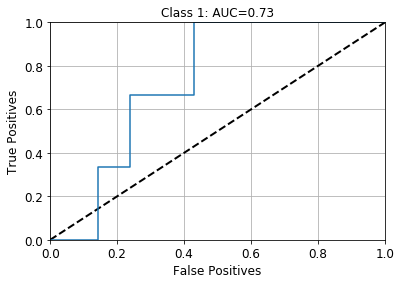

In [16]:
fig = make_roc_fig( 1 )
# fig.savefig( os.path.join( img_path, 'roc_1.png' ), dpi=216, format='png' )